In [1]:
# import ml packages

import string

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection as model_selection
from sklearn.metrics import confusion_matrix


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer

from sklearn.feature_extraction.text import (CountVectorizer, HashingVectorizer, TfidfVectorizer)
from imblearn.over_sampling import SMOTE

# from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, TruncatedSVD

In [56]:
train_df = pd.read_csv("./train.csv/train.csv")
test_df = pd.read_csv("./test.csv/test.csv")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [57]:
# create a preprocessing class
class Preprocessor:
    def __init__(self, df) -> None:
        self.df = df

    # convert all charecters to lower case
    def convertToLower(self):
        self.df["comment_text"] = self.df["comment_text"].apply(lambda x: x.lower())
        return self.df

    # remove stop words
    def removeStopWords(self):
        stop = stopwords.words("english")
        self.df["comment_text"] = self.df["comment_text"].apply(
            lambda x: " ".join([word for word in x.split() if word not in stop])
        )
        return self.df

    # remove punctuation
    def removePunctuation(self):
        self.df["comment_text"] = self.df["comment_text"].str.replace("[^\w\s]", "")
        return self.df

    # remove numbers
    def removeNumbers(self):
        self.df["comment_text"] = self.df["comment_text"].str.replace("[0-9]", "")
        return self.df

    # remove whitespaces
    def removeWhitespaces(self):
        self.df["comment_text"] = self.df["comment_text"].apply(
            lambda x: " ".join(x.split())
        )
        return self.df

    # remove urls
    def removeURLs(self):
        self.df["comment_text"] = self.df["comment_text"].str.replace(
            "https?://\S+|www\.\S+", ""
        )
        return self.df

    # snowball stemmer algorithm
    def snowballstemmer(self):
        stemmer = SnowballStemmer()

        def stem_words(text):
            return " ".join([stemmer.stem(word) for word in text.split()])

        self.df["comment_text"] = self.df["comment_text"].apply(
            lambda x: stem_words(x)
        )
        return self.df

    # port stemmer algorithm
    def porterstemmer(self):
        stemmer = PorterStemmer()

        def stem_words(text):
            return " ".join([stemmer.stem(word) for word in text.split()])

        self.df["comment_text"] = self.df["comment_text"].apply(
            lambda x: stem_words(x)
        )
        return self.df

    # lemmatizing
    def lemmatize(self):
        from nltk.stem import WordNetLemmatizer

        lemmatizer = WordNetLemmatizer()

        def lemmatize_words(text):
            return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

        self.df["comment_text"] = self.df["comment_text"].apply(
            lambda x: lemmatize_words(x)
        )
        return self.df

    # remove id and index columns
    def removeUnwantedCols(self, col):
        print(self.df.shape)
        self.df = self.df.drop(col, axis=1)
        return self.df

    # word tokenization using nltk
    def wordTokenization(self):
        self.df["comment_text"] = self.df["comment_text"].apply(
            lambda x: nltk.word_tokenize(x)
        )
        return self.df
        

    def preprocess(self):
        # self.df = self.convertToLower()
        # self.df = self.removeStopWords()
        # self.df = self.removePunctuation()
        # self.df = self.removeNumbers()
        # self.df = self.removeURLs()
        # self.df = self.removeWhitespaces()
        # self.df = self.snowballstemmer()
        # self.df = self.porterstemmer()
        # self.df = self.lemmatize()
        # self.df = self.wordTokenization()
        self.df = self.removeUnwantedCols(["id"])
        # self.df = self.removeUnwantedCols(["toxic"])
        # self.df = self.removeUnwantedCols(["severe_toxic"])
        # self.df = self.removeUnwantedCols(["obscene"])
        # self.df = self.removeUnwantedCols(["threat"])
        # self.df = self.removeUnwantedCols(["insult"])

        # print(self.df.head())
        return self.df

In [58]:
preproccesor = Preprocessor(train_df)
preprocessed_df = preproccesor.preprocess()
preprocessed_df.head()

(159571, 8)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
compression_opts = dict(method='zip', archive_name='out.csv')  
preprocessed_df.to_csv('out.zip', index=False, compression=compression_opts)  

In [59]:
# create a get train and test data class
from nltk.tokenize import RegexpTokenizer

class TrainTestData:
    def __init__(self, trainDf, testDf) -> None:
        self.trainDf = trainDf
        self.testDf = testDf

    def doSmote(self):
        sm = SMOTE()
        self.X, self.Y = sm.fit_resample(self.X, self.Y)
        return self.trainData, self.testData

    def doDecomposition(self):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(self.X)
        self.trainData = lsa.transform(self.X)
        self.testData = lsa.transform(self.testData)
        

    def get_X(self, minDocumentCount):

        # concatinate trainDf and testDf
        self.resampling()
        self.appendDf = pd.concat(
            [self.trainDf["comment_text"], self.testDf["comment_text"]], axis=0
        )

        token = RegexpTokenizer(r'[a-zA-Z0-9]+')
        self.vectorizer = CountVectorizer()
        #vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1,3),tokenizer=token.tokenize)
        # lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize
        self.vectorizer.fit(self.appendDf)

        self.trainData = self.vectorizer.transform(self.trainDf["comment_text"])
        print(self.trainData.shape)

        self.testData = self.vectorizer.transform(self.testDf["comment_text"])
        print(self.testData.shape)
        self.X = self.trainData

        # self.doDecomposition() 
        return self.X

    def resampling(self):
        from sklearn.utils import resample
        zero_data = self.trainDf[self.trainDf['identity_hate'] == 0]
        one_data = self.trainDf[self.trainDf['identity_hate'] == 1]
        self.trainDf = pd.concat([resample(zero_data, replace=True, n_samples=len(one_data)*6), one_data])
        return self.trainDf

    def get_Y(self):
        # self.resampling()
        self.Y = self.trainDf["identity_hate"]
        return self.Y

    def testTrainSplit(self):
        # self.doSmote()
        (
            self.X_train,
            self.X_test,
            self.Y_train,
            self.Y_test,
        ) = model_selection.train_test_split(
            self.X, self.Y, test_size=0.2, random_state=0
        )
        return self.X_train, self.X_test, self.Y_train, self.Y_test

    def get_X_test(self):
        return self.testData

    def get_X_test_custom(self, df):
        return self.vectorizer.transform(df["comment_text"])

In [60]:
testPreprocessor = Preprocessor(test_df)
preprocessed_test_df = testPreprocessor.preprocess()
preprocessed_test_df.head()

getTTData = TrainTestData(preprocessed_df, preprocessed_test_df)
X = getTTData.get_X(1)
y = getTTData.get_Y()
X_train, X_test, Y_train, Y_test = getTTData.testTrainSplit()

(153164, 2)
(9835, 254630)
(153164, 254630)


In [61]:
lrModel = LogisticRegression(C=0.70,solver="liblinear")
lrModel.fit(X_train, Y_train)

c:\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(C=0.7, solver='liblinear')

In [62]:
y_actual = Y_test
cv_preds = lrModel.predict(X_test)
print(cv_preds.shape)
from sklearn.metrics import fbeta_score

fbeta_score(y_actual, cv_preds, average="macro", beta=0.5)

(1967,)


0.8234362628661915

Text(0.5, 15.0, 'Predicted label')

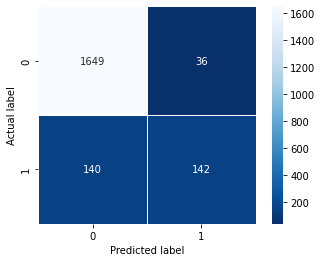

In [63]:
# use sns to plot the confusion matrix
cm = confusion_matrix(y_actual, cv_preds)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap="Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

In [67]:
check_dict = {"comment_text":["Sup, Gay piece of shit", "Hello there", "I don't like gays", "Fuck off faggot", "I am dhanush"]}
check_df = pd.DataFrame(check_dict) 
check_df

,comment_text
0,"Sup, Gay piece of shit"
1,Hello there
2,I don't like gays
3,Fuck off faggot
4,I am dhanush


In [68]:
class SubmissionPipeline:
    def __init__(self, testDf, model,testTrainData):
        self.testDf = testDf
        self.model = model
        self.getTTData = testTrainData

    def run(self):
        self.predictions = self.model.predict(getTTData.get_X_test_custom(self.testDf))
        self.submission_df = pd.DataFrame({"target": self.predictions})
        print(self.submission_df)

In [69]:
submissionPipeline = SubmissionPipeline(check_df, lrModel, getTTData)
submissionPipeline.run()

   target
0       1
1       0
2       0
3       1
4       0
